In [1]:
import os

import pandas as pd
import numpy as np

#### 1) Get list of organisations: used later to filter out tweets

In [3]:
#data downloaded anually from: https://data.4tu.nl/articles/dataset/Repository_of_fake_news_detection_datasets/14151755

orgs_table = pd.read_excel(
    'data/hum_data_iraq/iraq_3w_jan-to-dec_2021_longtable_20220120.xlsx', 
    sheet_name='3W longtable Jan-Dec 2021', 
    usecols=['Partner Acronym', 'Partner Full Name', 'Organisation type']
    )[1:]


iraq_covid = iraq_longtable = pd.read_excel(
    'data/hum_data_iraq/covid_and_noncovid_iraq_3w_jan-to-dec_2020_longtable_20210118.xlsx', 
    sheet_name='3W longtable Jan-Dec 2020', 
    usecols=['Partner Acronym', 'Partner Full Name', 'Organisation type']
    )[1:]

orgs_table = orgs_table.append(iraq_covid)
orgs_table.drop_duplicates(inplace=True)

orgs_table.head()

,Partner Acronym,Partner Full Name,Organisation type
1,DRC,Danish Refugee Council,INGO
2,SSORD,Sabea Sanabul Organization for Relief and Deve...,NNGO
3,Mercy Corps,Mercy Corps,INGO
5,DARY,DARY Organization,INGO
6,IRC,International Rescue Committee,INGO


In [4]:
print(f'there are {orgs_table.shape[0]} different organisations in this dataset')


there are 561 different organisations in this dataset


In [5]:
#which orgs type to keep????
orgs_table['Organisation type'].unique()

array(['INGO', 'NNGO', 'UN', 'Other', 'IO'], dtype=object)

- To be able to use this wied set of users, some processing needed:
    - not direct perfect matching (tweets usually contain faults)
    - translation of organisations to other problems   
<br>
- Problem: Complexity of filtering sentences explodes

In [2]:
def flatten(t):
    return [item for sublist in t for item in sublist]

### 2) trying different fact-checking datasets

In [9]:
# example of dataset found on the net about fact checking detection
# dataset found in this link: https://github.com/KaiDMML/FakeNewsNet/tree/master/dataset
os.listdir('data/FakeNewsNet-master/dataset')

['politifact_fake.csv',
 'politifact_real.csv',
 'gossipcop_real.csv',
 'gossipcop_fake.csv']

In [10]:
# example of dataset (not taslking about humanitarian organisations)
pd.read_csv('data/FakeNewsNet-master/dataset/politifact_fake.csv').head()

,id,news_url,title,tweet_ids
0,politifact15014,speedtalk.com/forum/viewtopic.php?t=51650,BREAKING: First NFL Team Declares Bankruptcy O...,937349434668498944\t937379378006282240\t937380...
1,politifact15156,politics2020.info/index.php/2018/03/13/court-o...,Court Orders Obama To Pay $400 Million In Rest...,972666281441878016\t972678396575559680\t972827...
2,politifact14745,www.nscdscamps.org/blog/category/parenting/467...,UPDATE: Second Roy Moore Accuser Works For Mic...,929405740732870656\t929439450400264192\t929439...
3,politifact14355,https://howafrica.com/oscar-pistorius-attempts...,Oscar Pistorius Attempts To Commit Suicide,886941526458347521\t887011300278194176\t887023...
4,politifact15371,http://washingtonsources.org/trump-votes-for-d...,Trump Votes For Death Penalty For Being Gay,915205698212040704\t915242076681506816\t915249...


In [11]:
# one other example: 'liar' dataset from huggingface
from datasets import load_dataset
dataset = load_dataset("liar")

Using custom data configuration default
Reusing dataset liar (/home/selim/.cache/huggingface/datasets/liar/default/1.0.0/479463e757b7991eed50ffa7504d7788d6218631a484442e2098dabbf3b44514)


In [14]:
huggningface_liar_data = pd.DataFrame(dataset['train'])[['label', 'statement', 'subject']]
huggningface_liar_data.head()

,label,statement,subject
0,0,Says the Annies List political group supports ...,abortion
1,1,When did the decline of coal start? It started...,"energy,history,job-accomplishments"
2,2,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy
3,0,Health care reform legislation is likely to ma...,health-care
4,1,The economic turnaround started at the end of ...,"economy,jobs"


In [15]:
print(f'In this dataset, there are {huggningface_liar_data.shape[0]} satements')

In this dataset, there are 10269 satements


In [13]:
#small characters, omit punctiation, add icrc, 
ICRC_tags = [
    'Red Crescent', 
    'Red Cross', 
    'الهلال الأحمر', 
    'Croix Rouge', 
    'ICRC', 
    'CICR',
    'Cruz Roja',
    'Croce Rossa'
    ]

augmented_punctuations = ["", "-", "_", " "]
augmented_tags = np.unique([tag.lower().replace(" ", punc) for tag in ICRC_tags for punc in augmented_punctuations])

augmented_tags 


array(['cicr', 'croce rossa', 'croce-rossa', 'croce_rossa', 'crocerossa',
       'croix rouge', 'croix-rouge', 'croix_rouge', 'croixrouge',
       'cruz roja', 'cruz-roja', 'cruz_roja', 'cruzroja', 'icrc',
       'red crescent', 'red cross', 'red-crescent', 'red-cross',
       'red_crescent', 'red_cross', 'redcrescent', 'redcross',
       'الهلال الأحمر', 'الهلال-الأحمر', 'الهلال_الأحمر', 'الهلالالأحمر'],
      dtype='<U13')

In [16]:
# No statement involves the ICRC
huggingface_liar_icrc_retalted_tweets = huggningface_liar_data[
    huggningface_liar_data.statement.apply(
        lambda x: any([name in x.lower() for name in  augmented_tags])
        )
    ]

huggingface_liar_icrc_retalted_tweets

,label,statement,subject


### 3) filtering out ICRC related tweets from taitter api data

In [28]:
columns_names = ['language', 'tweet']
cols = [3, 10]
data_original = pd.read_csv('data/tweets_data_jan18.csv', usecols=cols, names=columns_names).drop_duplicates(inplace=False)

In [29]:
data_original.head()

,language,tweet
0,it,Croce Rossa della Italia: https://t.co/lbnBTjx...
1,it,@annibale1962 @IULIUSAGRICOLA @distefanoTW @br...
2,it,Come ci si può fidare di testate del genere?\\...
3,it,@petroglifi @borghi_claudio @marcogirgi @Roghi...
4,it,Sassate contro l'auto della Croce rossa; forse...


In [31]:
from tqdm import tqdm

"""#use for loop to be able to know the time it will take
hum_data_related_tweets = []
for tweet_tmp in tqdm(data_original.tweet.unique()):
    lowered_tweet = tweet_tmp.lower()
    if any([name in lowered_tweet for name in  augmented_tags]):
        hum_data_related_tweets.append(tweet_tmp)"""

hum_data_related_tweets = data_original[
    data_original.tweet.apply(
        lambda x: any([name in x.lower() for name in  augmented_tags])
        )
    ]

In [23]:
print(f'{len(hum_data_related_tweets)} tweets talk about the ICRC')

22718 tweets talk about the ICRC


In [35]:
list(hum_data_related_tweets[hum_data_related_tweets.language=='en'].tweet)[:20]

['Great work! The @EG_Red_Crescent assistance programme in Northern #Sinai in collaboration with the @ICRC_ar in #Egypt https://t.co/xj93RVvTcP',
 "Mansour; a 4-year-old from Aden; lost his leg after being shot by a Houthi sniper during an attack on the south in 2015. His father was unable to treat him to help Mansour's father call him 734541408\\\n@ICRC_ar \\\n@msf_arabic \\\n@UNICEFinArabic https://t.co/jcZXkL4BtD",
 ".@ICRC @ICRC_ar @ICRC_sy @SYRedCrescent @UNHumanRights @ohchr_ar \\\nWhere were you when ASSad's monsters raped and tortured to death Syrian Children Women and Men?\\\nFYI @FamiliesSyria @amnesty @AmnestySyria @Amnesty_Schweiz https://t.co/51LUwCEMet",
 "@UN\\\n@realDonaldTrump\\\n@ICRC_ar\\\n⬇️\\\nIs not that enough for Iran's mullahs to go to hell?\\\nhttps://t.co/5GWXNZ7vnf\\\n#iranprotests #تظاهرات_سراسرى",
 '.@ICRC_ar Could you please help this child? She and her family were displaced to Damascus; and #Assad continues failing the most vulnerable. https://t.co/IbEWL

- Objective: filter out irrelevant tweets: Examples:   
`'Finance Responsible Job at International Committee of Red Cross ( ICRC… https://t.co/8DGzHBIxY4 Add your CV https://t.co/QmesFeMXbY'`,  
`'Finance Responsible Job at International Committee of Red Cross ( ICRC… https://t.co/8DGzHBIxY4 Add your CV'`,  
`'International Committee of the Red Cross (ICRC) https://t.co/HPH0CjcqB3'`,  
`'International Committee of the Red Cross (ICRC) https://t.co/GYAwD1yUet'`,

In [36]:
from transformers import pipeline

#extremly distilled model to have general understanding of models' performance
classifier = pipeline("zero-shot-classification", model="MoritzLaurer/xtremedistil-l6-h256-mnli-fever-anli-ling-binary")

In [37]:
from tqdm import tqdm

In [38]:
candidate_labels = ["relevant", "irrelevant"]

final_sents = []
for sent in tqdm(hum_data_related_tweets.tweet):
    res = classifier(sent, candidate_labels)
    final_sents.append(res)

100%|██████████| 22718/22718 [16:04<00:00, 23.54it/s]


In [46]:
#idea on output sctructure
final_sents[0]

{'sequence': 'Croce Rossa della Italia: https://t.co/lbnBTjxYfG #Italia #CroceRossa \\\n2018/1/14 17:27',
 'labels': ['relevant', 'irrelevant'],
 'scores': [0.6076647043228149, 0.3923352360725403]}

In [41]:
#relevant sentences
[sent['sequence'] for sent in sorted(final_sents, key=lambda d: d['scores'][1]) ][:20]

['This is IMPORTANT!  Help the #RedCross overcome a winter blood shortage. 1. Make an appt to #GiveNow at https://t.co/jJ62gftr0l 2. Ask a pal to give 3. Please retweet this msg https://t.co/bdVNgo380M',
 'We @ICRC produced this video several years ago. It’s still relevant - unfortunately - so we keep sharing it.  #NotATarget https://t.co/5REbl2PjkN',
 'Very important HELP #montecito #montecitomudslides #ThomasFire anything you can do to help please contact @RedCross &amp; @montecitofire https://t.co/iq5ODBf8nM',
 "I agree! If I were there; I'd lend a hand. #giveblood is so important! #savelives @RedCross https://t.co/wUMZWNoFs6",
 'Another reason why you should join us today! Find out how you can volunteer for the @BritishRedCross here https://t.co/6SLTBOBBGf https://t.co/SwmzLd6wNZ',
 'Keeping warm is important.  Keeping warm SAFELY is even more important!  #RedCross  #neoredcross https://t.co/wZQaeMqFLO',
 'This is so spot on. From my own experience charities like @RedCross and thei

In [42]:
#irrelevant sentences
[sent['sequence'] for sent in sorted(final_sents, key=lambda d: d['scores'][0]) ][:20]

['Red Cross disputes claims Milwaukee family was not provided assistance after house fire https://t.co/xZ2mjEstyH https://t.co/DF5NMQ37SW',
 "It's there under the red cross\\\n\\\nTonic has lots of sugar. Sugar is a problem. https://t.co/NIz3PTuw7v",
 'se siente impaciente en CRUZ ROJA MEXICANA DELEGACIÓN SALTILLO https://t.co/TUb3XmkYKT',
 "'RT Twiplomacy: The ICRC posted a chilling reply to Donald Trump’s nuclear sabre-rattling 🎥\\\nhttps://t.co/eXnGVgL5eN https://t.co/CtnI0TGKHs'",
 '@PolitiFact This is the same earthquake that American Red Cross collected millions to build housing and built none.',
 'You never know when you might need the $40 Red Cross emergency radio https://t.co/EKV50enWTi',
 '@BobbyJOnline @RedCross FACTS!!!! That’s why I’m like “nah” when they ask “would u like to donate...”',
 '@RealJamesWoods I never give to the Red Cross -- they have been screwing over donors for decades; deflecting &amp; stealing donations -- there are a lot of other relief organizations wh

- remarqs:
    - irrelevant sentences tend to satisfy more our purposes
    - use it as a base for beeter searching, keyword based for now:  
    `Doesn't Q talk about the Red Cross Scam`,  
    `@yankifarber The Red Cross is a joke. CEO makes A LOT of money. Never give to them. Salvation army is good.`  
    `@PolitiFact This is the same earthquake that American Red Cross collected millions to build housing and built none.`  
<br>
- In the end, model helped out filter well structured sentences. 
    

In [50]:
import pickle
with open("relevancy_scores", "wb") as fp:   #Pickling
    pickle.dump(sorted(final_sents, key=lambda d: d['scores'][0]), fp)

Text(0.5, 1.0, 'barplot of relevancy scores')

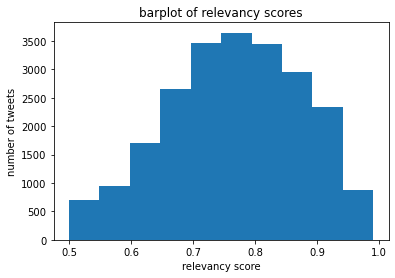

In [49]:
import matplotlib.pyplot as plt
entailement_scores = [sent['scores'][0] for sent in final_sents]
plt.hist(entailement_scores)
plt.xlabel('relevancy score')
plt.ylabel('number of tweets')
plt.title('barplot of relevancy scores')

- proposed work:
    - take the data sorted with respect to the zero shot model and work on labeling it (first entries have the most chances of being positives)
    - finetune models pretrained on twitter data (deal with data specifications, #, @, vocabulary etc.)